# **Intro**
In this notebook I set up semi-supervised VAE that disentangles the rotation and digits of MNIST numbers. 
This is almost identical to "[DIVA: DOMAIN INVARIANT VARIATIONAL AUTOENCODERS](https://arxiv.org/pdf/1905.10427.pdf)".
To breifly describe the model, we have 3 independent encoders that encode for different sources of variation: rotation, digit, and everything else (slack).
To enforce this disentanglement, there are classification losses on the rotation and digit embeddings.
The embeddings are then concatenated together and used as input to a joint decoder.
When used in the semi-supervised mode, the classification loss is calculated by comparing the classifier output to the latent digit representation.
The model is depicted below.

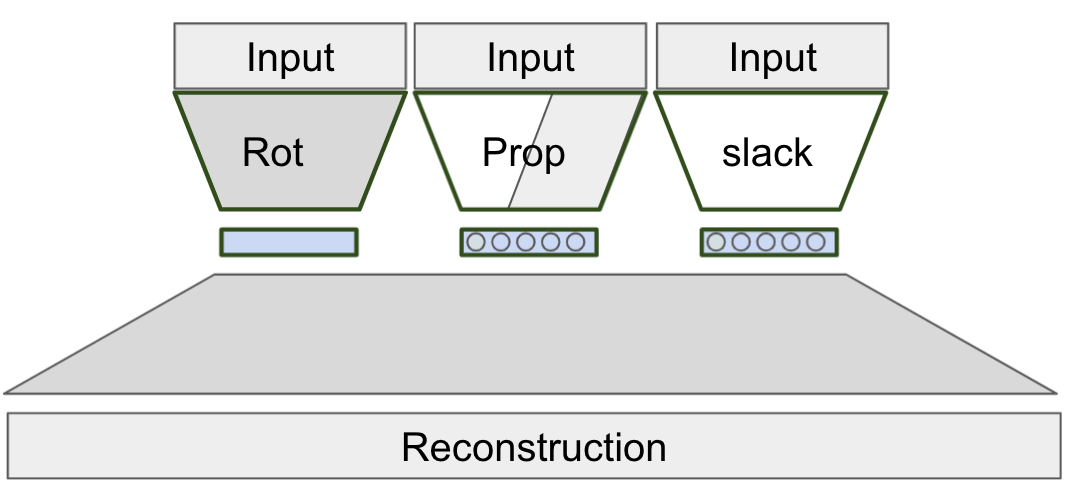


The experimental set-up is as follows:
The numbers are rotated 0, 15, 30, 45, 60, and 75 degrees. 
The model differentiates domains (rotations, referred to as *labels* in the code) from predicted values (digits, , referred to as *Y* in the code). 
The idea is to be able to provide correct labels in a new domain. 
The semi-supervision section has a new domain (30 degrees) without a Y (no digit).


This is analogous to the following situation: 
single-cell profiles where a patient or sequencing method is the domain (noise we would like to remove) and cell type (the label) is what we would like to predict.
This is done in a semi-supervised fashion because we would like to use bulk data in addition to single-cell.
However, bulk data is assumed to be a sum over many cell-types (i.e. we don't know the labels).
There is one simplification in this approach -- we predict a single-cell type for now.
Realistically, we predict a continuous vector of cell-type proportions.
Currently, we predict a 1-hot representation of cell-type identity.

Using both of these sources of data we hope that we can work on OOD stuff.
We focus on interpolation, not extrapolation, but this is not directly done in this notebook.

This code was based off of DIVA's codebase: https://github.com/AMLab-Amsterdam/DIVA

Semi-supervised training method was take from here:
And this tutorial: https://github.com/bjlkeng/sandbox/tree/master/notebooks/vae-semi_supervised_learning with an awesome accomanying blogpost: https://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/

Another codebase referenced: https://github.com/saemundsson/semisupervised_vae


# **Imports**

In [134]:
# import the our code
import sys
sys.path.insert(1, '../../')
from sc_preprocessing import sc_preprocess

# general imports
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from scipy.stats import spearmanr, pearsonr


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale


# programming stuff
import time
import os, sys
import pickle
from pathlib import Path


# **Set up experiment parameters** 


In [135]:

# number of pseudobulks PER patient
n_train = 1000

### create the domains label 

# first for 10x data
Label_full_10x = np.concatenate([np.full(n_train, 0), np.full(n_train, 1),
                            np.full(n_train, 2), np.full(n_train, 3),
                            np.full(n_train, 4), np.full(n_train, 5),
                            np.full(n_train, 6), np.full(n_train, 7),
                            np.full(n_train, 8), np.full(n_train, 9),
                            np.full(n_train, 10), np.full(n_train, 11)], axis=0)
label_full_10x = to_categorical(Label_full_10x)

# the 11th example is unlabeled is we train only
# using 10x data
unlabeled_10x_only_idx = 11

# now for sm2 data
Label_full_sm2 = np.concatenate([np.full(n_train, 0), np.full(n_train, 1), 
                                np.full(n_train, 2), np.full(n_train, 3),
                                np.full(n_train, 4), np.full(n_train, 5)], axis=0)


# when we train on 10x and sm2 we put them together
Label_both = np.concatenate([Label_full_10x, Label_full_sm2+12])
label_both = to_categorical(Label_both)

# we append an additional binary value to indicate sm2 or 10x
Label_both_dim = np.full(n_train*12, 0)
Label_both_sm2_dim = np.full(n_train*6, 1)
Label_both_dim = np.concatenate([Label_both_dim, Label_both_sm2_dim])
Label_both_dim = to_categorical(Label_both_dim)


# **Load Data**

In [136]:

res_path = f"{os.getcwd()}/../../results/single_cell_data/diva_pbmc/"
bp_res_path = f"{os.getcwd()}/../../results/single_cell_data/bp_pbmc/"
cs_res_path = f"{os.getcwd()}/../../results/single_cell_data/cibersort_pbmc/"
data_path = f"{os.getcwd()}/../../data/single_cell_data/augmented_pbmc_data/"

def read_gene_file(res_path, exp_id):
    gene_file = os.path.join(res_path, f"train-{exp_id}-DIVA_features.pkl")
    gene_path = Path(gene_file)
    gene_df_train = pickle.load( open( gene_path, "rb" ) )
    return gene_df_train


exp_id = "pbmc_rep2_sm2"
pbmc_rep2_sm2_X, pbmc_rep2_sm2_Y, pbmc_rep2_sm2_gene_df = sc_preprocess.read_all_diva_files(data_path, range(6), exp_id)
pbmc_rep2_sm2_X.columns = pbmc_rep2_sm2_gene_df["gene_ids"]


exp_id = "pbmc_rep1_sm2"
pbmc_rep1_sm2_X, pbmc_rep1_sm2_Y, pbmc_rep1_sm2_gene_df = sc_preprocess.read_all_diva_files(data_path, range(6), exp_id)
pbmc_rep1_sm2_X.columns = pbmc_rep1_sm2_gene_df["gene_ids"]


exp_id = "pbmc_rep2_10xV2_sm2_cells"
pbmc_rep2_10xV2_sm2_cells_X, pbmc_rep2_10xV2_sm2_cells_Y, pbmc_rep2_10xV2_sm2_cells_gene_df = sc_preprocess.read_all_diva_files(data_path, range(12), exp_id)
pbmc_rep2_10xV2_sm2_cells_X.columns = pbmc_rep2_10xV2_sm2_cells_gene_df["gene_ids"]


lab_id = "pbmc_rep2_10xV2_sm2_cells"
unlab_id = "pbmc_rep2_sm2"
pbmc_rep2_sm2_enc = tf.keras.models.load_model(f"{res_path}/{lab_id}_{unlab_id}_encoder")
pbmc_rep2_sm2_train = read_gene_file(res_path, f"{lab_id}-{unlab_id}")

lab_id = "pbmc_rep2_10xV2_sm2_cells"
unlab_id = "pbmc_rep2_10xV2_sm2_cells"
pbmc_rep2_10xV2_sm2_cells_enc = tf.keras.models.load_model(f"{res_path}/{lab_id}_{unlab_id}_encoder")
pbmc_rep2_10xV2_sm2_cells_train = read_gene_file(res_path, f"{lab_id}-{unlab_id}")



# **Make TSNE of raw and training data**

In [137]:
def make_tsne_fig(X_df, color_vec, ax, title):
    ## plot samples
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        tsne = TSNE(n_components=2, verbose=0, perplexity=40, init="pca", learning_rate='auto')
        tsne_results = tsne.fit_transform(scale(np.log2(X_df+1), axis=1))

    plot_df = pd.DataFrame(tsne_results[:,0:2])
    print(tsne_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['tsne_0', 'tsne_1']
    plot_df['class'] = color_vec

    n_colors = len(np.unique(color_vec))
    g = sns.scatterplot(
        x="tsne_0", y="tsne_1",
        data=plot_df,
        hue="class",
        palette=sns.color_palette("hls", n_colors),
        legend="full",
        alpha=0.3, ax= ax
    )
    ax.set_title(title)
    return g



(6000, 2)
(6000, 2)
(6000, 2)
(6000, 2)
(6000, 2)
(6000, 2)
(6000, 2)
(6000, 2)
(12000, 2)
(12000, 2)
(12000, 2)
(12000, 2)


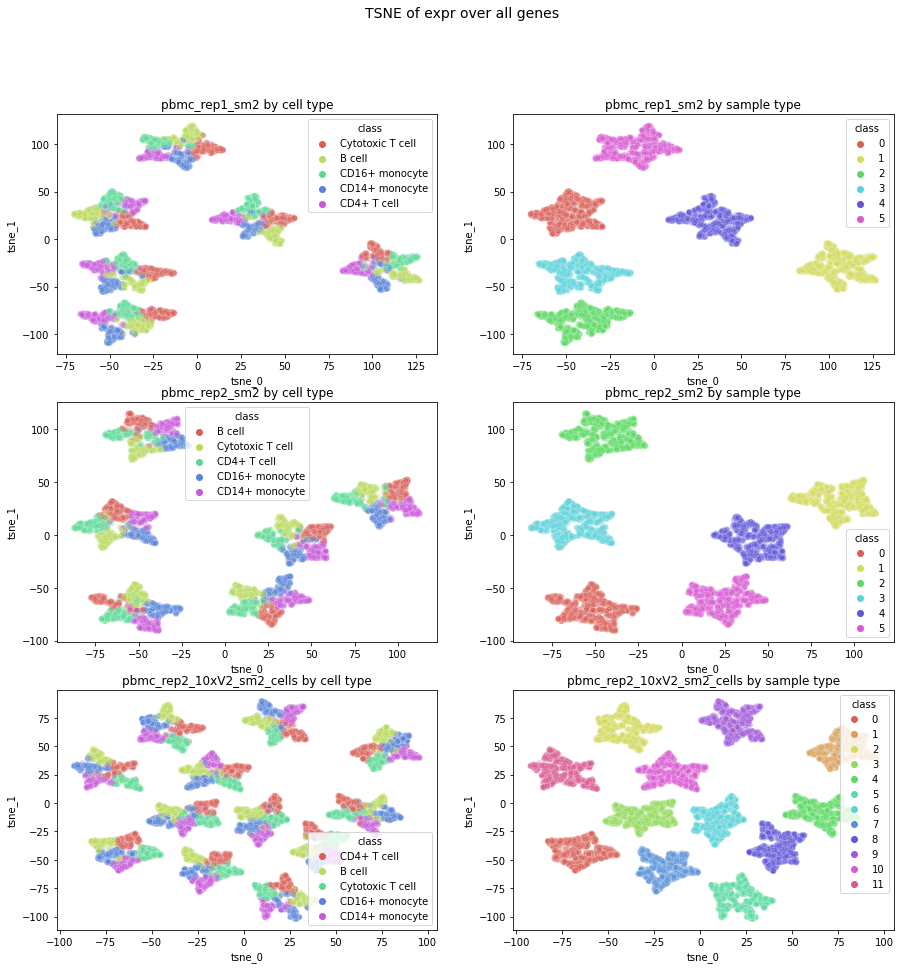

In [173]:
# plot over all genes


fig, axs = plt.subplots(3, 2, figsize=(15,15))
tmp_Y = pbmc_rep1_sm2_Y
tmp_Y = tmp_Y.to_numpy()
tmp_Y = pbmc_rep2_sm2_Y.columns[np.argmax(tmp_Y, axis=1)]
make_tsne_fig(pbmc_rep1_sm2_X, tmp_Y, ax=axs[0,0], title="pbmc_rep1_sm2 by cell type")
make_tsne_fig(pbmc_rep1_sm2_X, Label_full_sm2, ax=axs[0,1], title="pbmc_rep1_sm2 by sample type")



tmp_Y = pbmc_rep2_sm2_Y
tmp_Y = tmp_Y.to_numpy()
tmp_Y = pbmc_rep2_sm2_Y.columns[np.argmax(tmp_Y, axis=1)]
make_tsne_fig(pbmc_rep2_sm2_X, tmp_Y, ax=axs[1,0], title="pbmc_rep2_sm2 by cell type")
make_tsne_fig(pbmc_rep2_sm2_X, Label_full_sm2, ax=axs[1,1], title="pbmc_rep2_sm2 by sample type")


tmp_Y = pbmc_rep2_10xV2_sm2_cells_Y
tmp_Y = tmp_Y.to_numpy()
tmp_Y = pbmc_rep2_sm2_Y.columns[np.argmax(tmp_Y, axis=1)]
make_tsne_fig(pbmc_rep2_10xV2_sm2_cells_X, tmp_Y, ax=axs[2,0], title="pbmc_rep2_10xV2_sm2_cells by cell type")
make_tsne_fig(pbmc_rep2_10xV2_sm2_cells_X, Label_full_10x, ax=axs[2,1], title="pbmc_rep2_10xV2_sm2_cells by sample type")

fig.suptitle("TSNE of expr over all genes", fontsize=14)

fig.show()

In [172]:
pbmc_rep2_sm2_Y

CD14+ monocyte    B cell CD16+ monocyte Cytotoxic T cell CD4+ T cell
0           0.064     0.618           0.18             0.02       0.118
0           0.226     0.598          0.086            0.076       0.014
0           0.018      0.23          0.014            0.708        0.03
0           0.034     0.782          0.152            0.012        0.02
0           0.158     0.304          0.034             0.15       0.354
..            ...       ...            ...              ...         ...
0        0.921667  0.003333       0.001667         0.069667    0.003667
0        0.127667     0.214          0.057            0.453    0.148333
0           0.066  0.089667       0.060667         0.113667        0.67
0        0.580333     0.307       0.054333         0.019667    0.038667
0        0.235333     0.051       0.306667            0.338       0.069

[6000 rows x 5 columns]

# plot over only genes used in testing


fig, axs = plt.subplots(3, 2, figsize=(15,15))
tmp_Y = pbmc_rep1_sm2_Y
tmp_Y = tmp_Y.to_numpy()
tmp_Y = np.argmax(tmp_Y, axis=1)
tmp_X = pbmc_rep1_sm2_X[pbmc_rep2_10xV2_sm2_cells_train["gene_ids"]]
make_tsne_fig(tmp_X, tmp_Y, ax=axs[0,0], title="pbmc_rep1_sm2 by cell type")
make_tsne_fig(tmp_X, Label_full_sm2, ax=axs[0,1], title="pbmc_rep1_sm2 by sample type")


tmp_Y = pbmc_rep2_sm2_Y
tmp_Y = tmp_Y.to_numpy()
tmp_Y = np.argmax(tmp_Y, axis=1)
tmp_X = pbmc_rep2_sm2_X[pbmc_rep2_10xV2_sm2_cells_train["gene_ids"]]
make_tsne_fig(pbmc_rep2_sm2_X, tmp_Y, ax=axs[1,0], title="pbmc_rep2_sm2 by cell type")
make_tsne_fig(pbmc_rep1_sm2_X, Label_full_sm2, ax=axs[1,1], title="pbmc_rep2_sm2 by sample type")


tmp_Y = pbmc_rep2_10xV2_sm2_cells_Y
tmp_Y = tmp_Y.to_numpy()
tmp_Y = np.argmax(tmp_Y, axis=1)
tmp_X = pbmc_rep2_10xV2_sm2_cells_X[pbmc_rep2_10xV2_sm2_cells_train["gene_ids"]]
make_tsne_fig(tmp_X, tmp_Y, ax=axs[2,0], title="pbmc_rep2_10xV2_sm2_cells by cell type")
make_tsne_fig(tmp_X, Label_full_10x, ax=axs[2,1], title="pbmc_rep2_10xV2_sm2_cells by sample type")

fig.suptitle("TSNE of expr over 1000 most variable genes", fontsize=14)

fig.show()


# **Plot Loss Curves**

In [139]:
def read_loss_file(res_path, exp_id, unlab_id):
    loss_file = os.path.join(res_path, f"train-{exp_id}-{unlab_id}-DIVA_loss.pkl")
    loss_path = Path(loss_file)
    loss_df = pickle.load( open( loss_path, "rb" ) )
    return loss_df

def make_loss_fig(loss_df, ax, title, loss_to_plot):
    ## plot loss
    g = sns.lineplot(
        x="batch", y=loss_to_plot,
        data=loss_df,
        hue="type",
        legend="full",
        alpha=0.3, ax= ax
    )
    ax.set_title(title)
    return g





## **Total Loss**

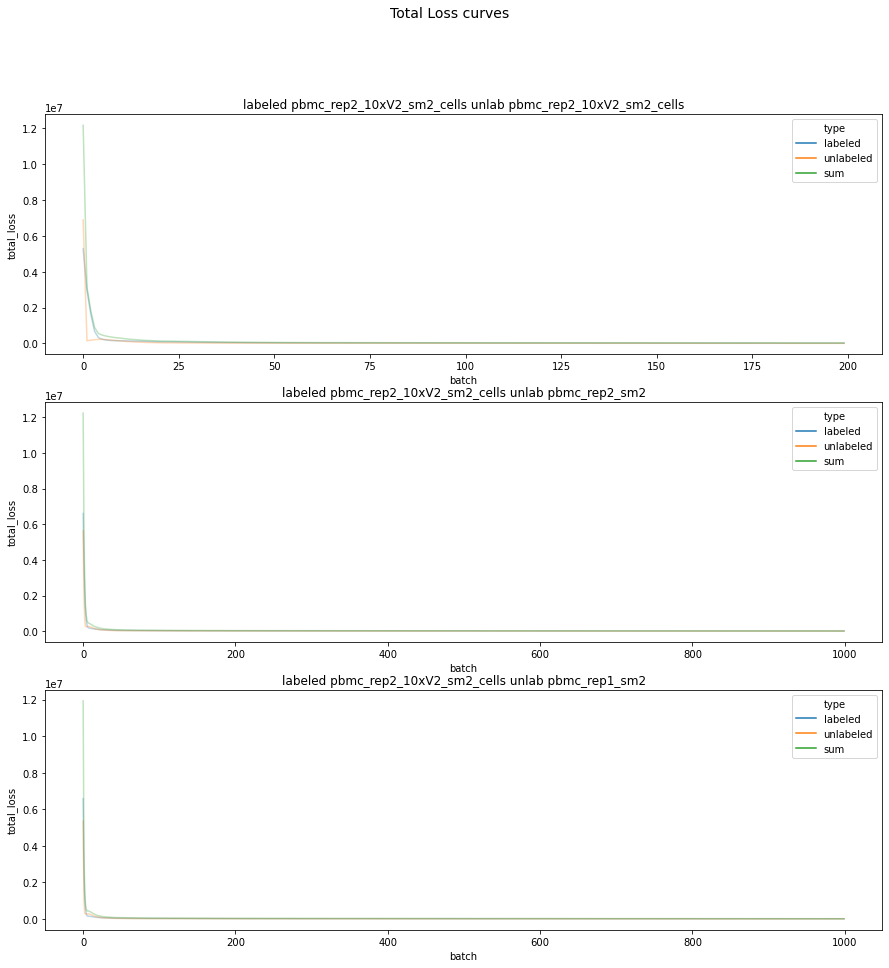

In [140]:
loss_to_plot = "total_loss"
fig, axs = plt.subplots(3, figsize=(15,15))

exp_id="pbmc_rep2_10xV2_sm2_cells"
unlab_exp_id="pbmc_rep2_10xV2_sm2_cells"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
make_loss_fig(loss_df1, ax=axs[0], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)


exp_id="pbmc_rep2_10xV2_sm2_cells"
unlab_exp_id="pbmc_rep2_sm2"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
make_loss_fig(loss_df1, ax=axs[1], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)


exp_id="pbmc_rep2_10xV2_sm2_cells"
unlab_exp_id="pbmc_rep1_sm2"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
make_loss_fig(loss_df1, ax=axs[2], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)



fig.suptitle("Total Loss curves", fontsize=14)

fig.show()

## **Reconstruction Loss**

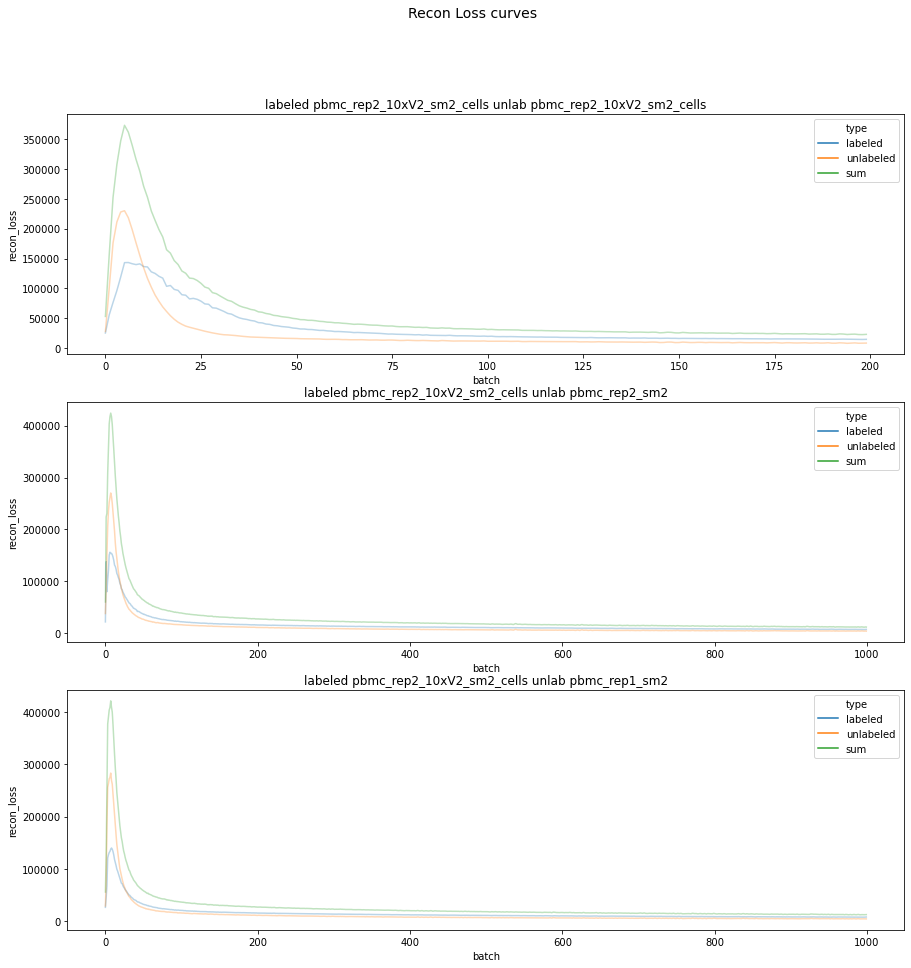

In [141]:
loss_to_plot = "recon_loss"
fig, axs = plt.subplots(3, figsize=(15,15))

exp_id="pbmc_rep2_10xV2_sm2_cells"
unlab_exp_id="pbmc_rep2_10xV2_sm2_cells"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
make_loss_fig(loss_df1, ax=axs[0], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)


exp_id="pbmc_rep2_10xV2_sm2_cells"
unlab_exp_id="pbmc_rep2_sm2"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
make_loss_fig(loss_df1, ax=axs[1], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)


exp_id="pbmc_rep2_10xV2_sm2_cells"
unlab_exp_id="pbmc_rep1_sm2"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
make_loss_fig(loss_df1, ax=axs[2], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)



fig.suptitle("Recon Loss curves", fontsize=14)

fig.show()

## **Proportion Loss**

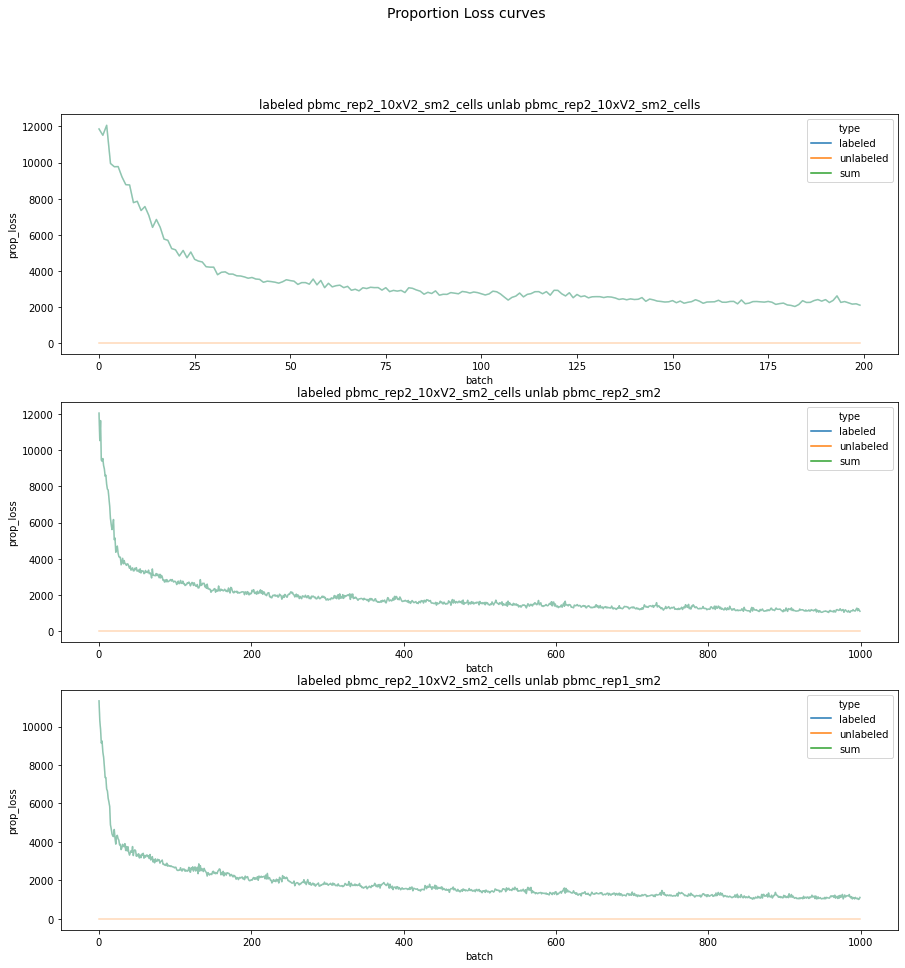

In [142]:
loss_to_plot = "prop_loss"
fig, axs = plt.subplots(3, figsize=(15,15))

exp_id="pbmc_rep2_10xV2_sm2_cells"
unlab_exp_id="pbmc_rep2_10xV2_sm2_cells"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
make_loss_fig(loss_df1, ax=axs[0], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)


exp_id="pbmc_rep2_10xV2_sm2_cells"
unlab_exp_id="pbmc_rep2_sm2"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
make_loss_fig(loss_df1, ax=axs[1], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)


exp_id="pbmc_rep2_10xV2_sm2_cells"
unlab_exp_id="pbmc_rep1_sm2"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
make_loss_fig(loss_df1, ax=axs[2], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)



fig.suptitle("Proportion Loss curves", fontsize=14)

fig.show()

## **Sample Prediction Loss**

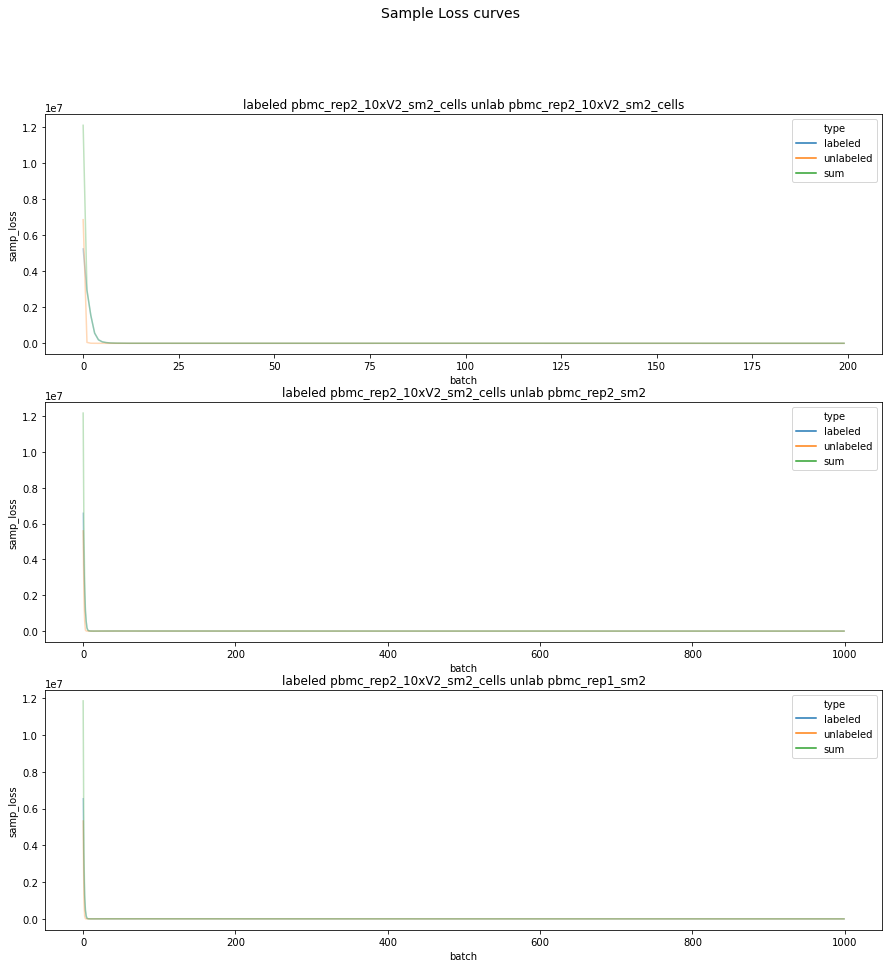

In [143]:
loss_to_plot = "samp_loss"
fig, axs = plt.subplots(3, figsize=(15,15))

exp_id="pbmc_rep2_10xV2_sm2_cells"
unlab_exp_id="pbmc_rep2_10xV2_sm2_cells"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
make_loss_fig(loss_df1, ax=axs[0], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)


exp_id="pbmc_rep2_10xV2_sm2_cells"
unlab_exp_id="pbmc_rep2_sm2"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
make_loss_fig(loss_df1, ax=axs[1], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)


exp_id="pbmc_rep2_10xV2_sm2_cells"
unlab_exp_id="pbmc_rep1_sm2"
loss_df1 = read_loss_file(res_path, exp_id, unlab_exp_id)
make_loss_fig(loss_df1, ax=axs[2], title=f"labeled {exp_id} unlab {unlab_exp_id}", loss_to_plot=loss_to_plot)



fig.suptitle("Sample Loss curves", fontsize=14)

fig.show()

# **Plot Encodings**

## TSNE on training data

Here we are now interested in training on pbmc_rep1_10xV2a and testing on other settings.
So we will first show how well we perform on our training data

In [144]:
   
def get_tsne_for_plotting(encodings):
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(encodings)

    plot_df = pd.DataFrame(tsne_results[:,0:2])
    print(tsne_results.shape)
    print(plot_df.shape)
    plot_df.columns = ['tsne_0', 'tsne_1']
    return plot_df

def plot_tsne(plot_df, color_vec, ax, title):

    plot_df['Y'] = color_vec

    g = sns.scatterplot(
        x="tsne_0", y="tsne_1",
        data=plot_df,
        hue="Y",
        palette=sns.color_palette("hls", len(np.unique(color_vec))),
        legend="full",
        alpha=0.3, ax= ax
    )

    ax.set_title(title)
    return g




Number unique Y: 5
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 4.215s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.053058
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.293961
[t-SNE] KL divergence after 300 iterations: 2.679384
(10000

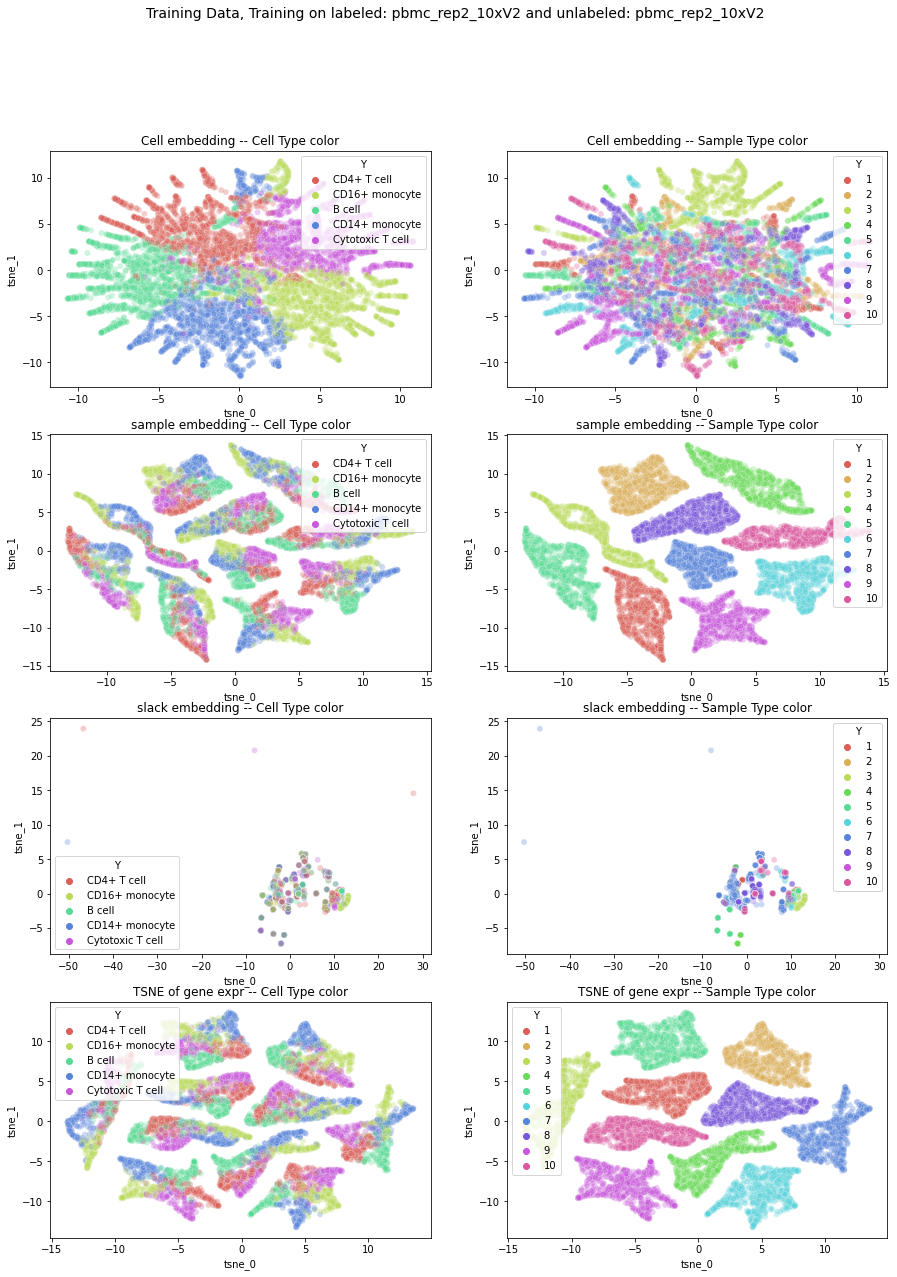

In [171]:
batch_size = 500
# plot proportions on labeled 10x and unlabeled 10x
# this is the training data
idx_train = np.where(np.logical_and(Label_full_10x!=unlabeled_10x_only_idx, Label_full_10x!=0))[0]
idx_unlab = np.where(Label_full_10x==unlabeled_10x_only_idx)[0]

X_temp = pbmc_rep2_10xV2_sm2_cells_X.reindex(columns=pbmc_rep2_10xV2_sm2_cells_train["gene_ids"], fill_value=0)
X_temp = X_temp.to_numpy()
X_temp = X_temp[idx_train]
X_temp = scale(X_temp, axis=1)

Y_temp = pbmc_rep2_10xV2_sm2_cells_Y
Y_temp = pbmc_rep2_10xV2_sm2_cells_Y.columns[np.argmax(Y_temp.to_numpy(), axis=1)]
Y_temp = Y_temp[idx_train]

label_temp = Label_full_10x[idx_train]


print(f"Number unique Y: {len(np.unique(Y_temp))}")

_, mu_slack, _, mu_prop, _, prop_outputs, _, mu_rot, _ = pbmc_rep2_10xV2_sm2_cells_enc.predict(X_temp, batch_size=batch_size)
z_test = mu_prop
encodings= np.asarray(z_test)


fig, axs = plt.subplots(4, 2, figsize=(15,20))

plot_df = get_tsne_for_plotting(np.asarray(mu_prop))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[0,0], title="Cell embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[0,1], title="Cell embedding -- Sample Type color")

plot_df = get_tsne_for_plotting(np.asarray(mu_rot))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[1,0], title="sample embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[1,1], title="sample embedding -- Sample Type color")

plot_df = get_tsne_for_plotting(np.asarray(mu_slack))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[2,0], title="slack embedding -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[2,1], title="slack embedding -- Sample Type color")

plot_df = get_tsne_for_plotting(np.asarray(X_temp))
plot_tsne(plot_df, color_vec=Y_temp, ax=axs[3,0], title="TSNE of gene expr -- Cell Type color")
plot_tsne(plot_df, color_vec=label_temp, ax=axs[3,1], title="TSNE of gene expr -- Sample Type color")



fig.suptitle("Training Data, Training on labeled: pbmc_rep2_10xV2 and unlabeled: pbmc_rep2_10xV2", fontsize=14)

fig.show()


# **Predict on our noise**

## Set-up Methods

In [148]:
def read_diva_result_file(res_path, train_id, test_id, unlab_id):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-unlab-{unlab_id}-DIVA.pkl")
    res_path = Path(res_file)
    res_df = pickle.load( open( res_path, "rb" ) )
    return res_df

def read_bp_result_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df

def read_bp_init_file(res_path, train_id, test_id, num_samp=1000):
    res_file = os.path.join(res_path, f"train-{train_id}-test-{test_id}-bp_{num_samp}_init.tsv")
    res_df = pd.read_csv(res_file, sep="\t")
    return res_df


In [149]:
# helper methods for evaluation
def sum_abs_error(y_pred, y_true):
  return sum(abs(y_pred - y_true))

def mean_abs_error(y_pred, y_true):
  return np.mean(abs(y_pred - y_true))

def mean_sqr_error(y_pred, y_true):
  return np.mean((y_pred - y_true)**2)

def get_errors(y_true, y_est):
  mse_err = [mean_sqr_error(y_true[idx], y_est[idx]) 
                  for idx in range(0, y_est.shape[0])]

  print(f"MSqE mean: {np.mean(mse_err)}, median: {np.median(mse_err)}, max: {max(mse_err)}")

  spr_err = [spearmanr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Spearman mean: {np.mean(spr_err)}, median: {np.median(spr_err)}, max: {max(spr_err)}")

  pear_err = [pearsonr(y_true[idx].astype(float), y_est[idx].astype(float))[0]
                    for idx in range(0, y_est.shape[0])]
  print(f"Pearson mean: {np.mean(pear_err)}, median: {np.median(pear_err)}, max: {max(pear_err)}")

  error_list = [mse_err, spr_err, pear_err]
  plot_df = [item for sublist in error_list for item in sublist]
  plot_df = pd.DataFrame(plot_df)
  plot_df.columns = ["error"]
  plot_df["error_type"] = ["MSQ"]*y_est.shape[0] + ["SPR"]*y_est.shape[0] + ["PEAR"]*y_est.shape[0]

  return plot_df



In [150]:
def plot_cell_specific_corr(xval, yval, ax, title, xlab, ylab):

    plot_df = pd.DataFrame(list(zip(xval, yval)))
    plot_df.columns = [xlab, ylab]

    g = sns.scatterplot(
        x=xlab, y=ylab,
        data=plot_df,ax=ax
    )
    g.set(ylim=(0, 1))
    g.set(xlim=(0, 1))
    g.plot([0, 1], [0, 1], transform=g.transAxes)

    ax.set_title(title)
    return g

## First test only on re-sampled noise

We plot the Mean Squared Error (MSQ) and Pearson correlation with ground truth cell-type proportions.
This is compared between BuDDI and BayesPrism (BP)

MSqE mean: 0.011396030276583083, median: 0.007401032512769131, max: 0.07737333793637417
Spearman mean: 0.6357707297539027, median: 0.7, max: 1.0
Pearson mean: 0.8379233633997774, median: 0.938757415995933, max: 0.9999754938004533
MSqE mean: 0.036736774919826985, median: 0.02867831106928745, max: 0.14221762016701073
Spearman mean: 0.45200474873007057, median: 0.49999999999999994, max: 0.9999999999999999
Pearson mean: 0.566160374014725, median: 0.7172749384348206, max: 0.9881216228852105


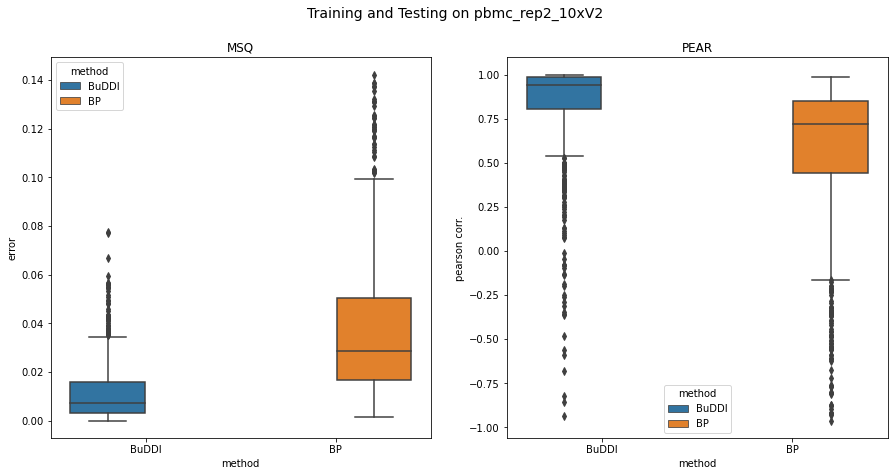

In [174]:
# first we test within the same sample
within_sample_test_diva  = read_diva_result_file(res_path, "pbmc_rep2_10xV2_sm2_cells", "pbmc_rep2_10xV2_sm2_cells", "pbmc_rep2_10xV2_sm2_cells")
within_sample_test_bp  = read_bp_result_file(bp_res_path, "pbmc_rep2_10xV2_sm2_cells_0", "pbmc_rep2_10xV2_sm2_cells_0", num_samp=1000)
within_sample_test_bp = within_sample_test_bp.reindex(columns=within_sample_test_diva.columns, fill_value=0)

_, Y_test_df, test_gene_df, _ = sc_preprocess.read_diva_files(data_path, 0, "pbmc_rep2_10xV2_sm2_cells")

Y_test_df = Y_test_df[within_sample_test_diva.columns]
Y_test = Y_test_df.to_numpy()

within_sample_test_bp = within_sample_test_bp[within_sample_test_diva.columns]

biorep_diva_err = get_errors(Y_test, within_sample_test_diva.to_numpy())
biorep_bp_err = get_errors(Y_test, within_sample_test_bp.to_numpy())

biorep_diva_err["experiment"] = ["2_biorep"]*biorep_diva_err.shape[0]
biorep_diva_err["method"] = ["BuDDI"]*biorep_diva_err.shape[0]

biorep_bp_err["experiment"] = ["2_biorep"]*biorep_bp_err.shape[0]
biorep_bp_err["method"] = ["BP"]*biorep_bp_err.shape[0]

plot_df = pd.concat([biorep_diva_err, biorep_bp_err])

fig, axs = plt.subplots(1, 2, figsize=(15,7))
sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="method", y="error",
            hue="method", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="method", y="error",
            hue="method", ax= axs[1])
axs[1].set_title("PEAR")
axs[1].set(ylabel="pearson corr.")
fig.suptitle("Training and Testing on pbmc_rep2_10xV2", fontsize=14)

fig.show()

Now we plot the correlation across samples for a single cell type.
This is compared between BuDDI and BayesPrism (BP)

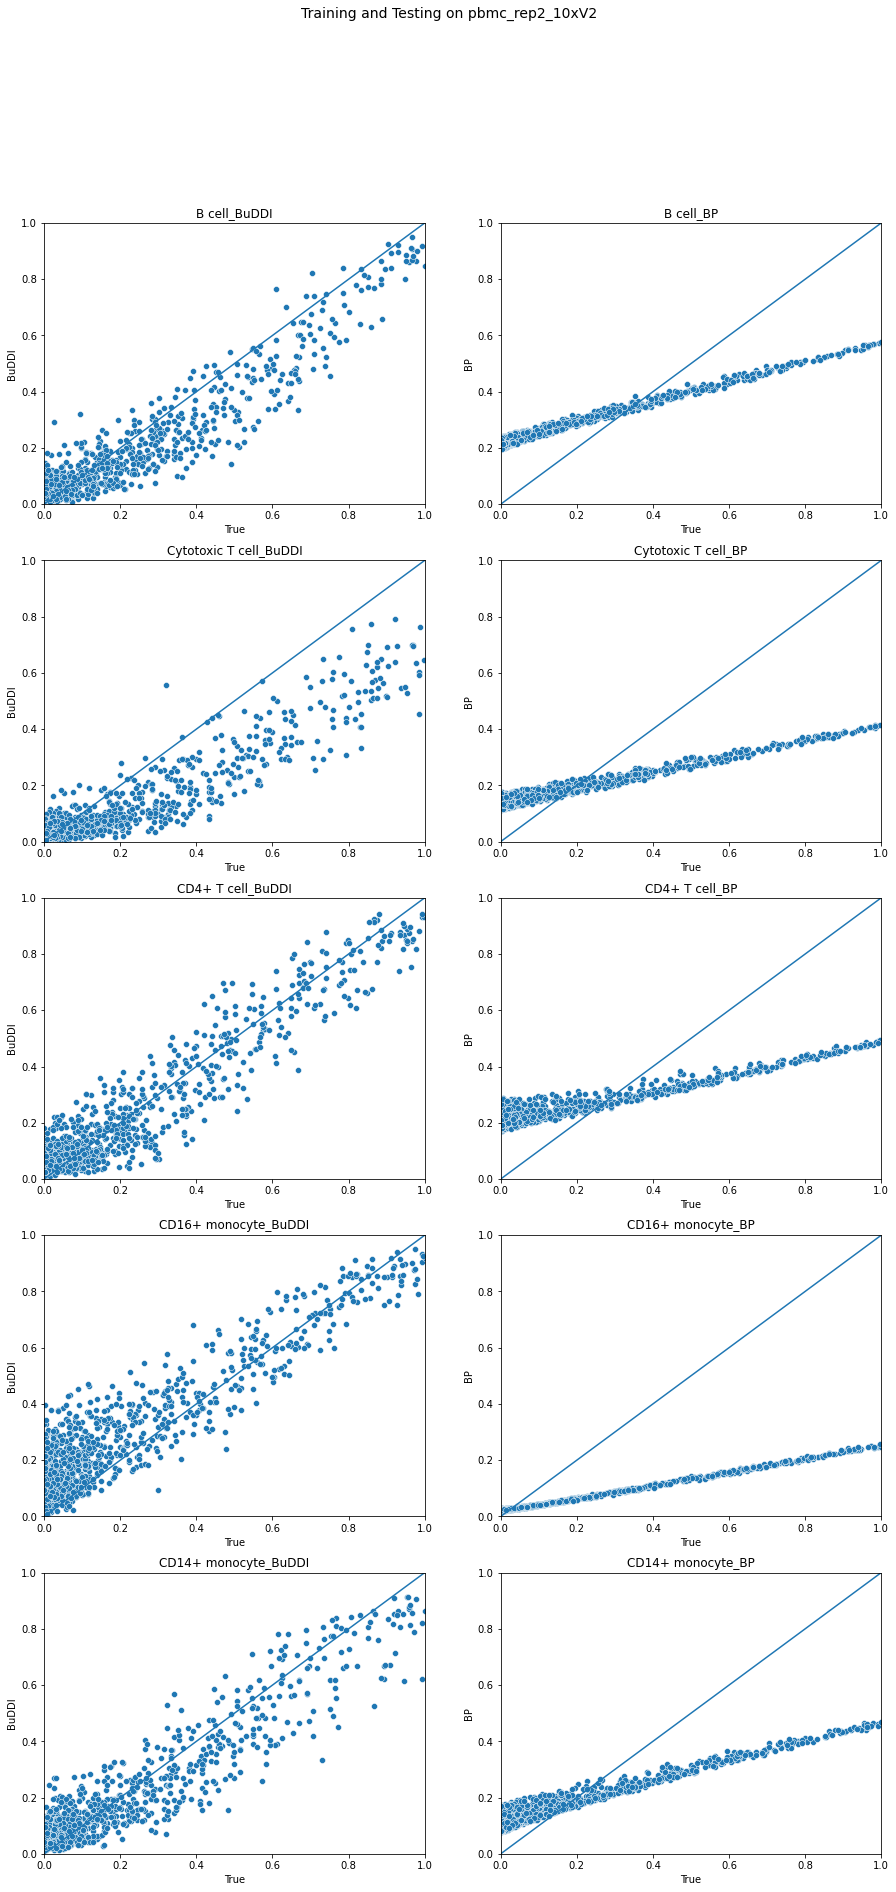

In [175]:

fig, axs = plt.subplots(5, 2, figsize=(15,30))
row_idx = 0
for curr_cell in Y_test_df.columns:

    plot_cell_specific_corr(Y_test_df[curr_cell], within_sample_test_diva[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI", xlab="True", ylab="BuDDI")
    plot_cell_specific_corr(Y_test_df[curr_cell], within_sample_test_bp[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BP", xlab="True", ylab="BP")
    row_idx = row_idx +1


fig.suptitle("Training and Testing on pbmc_rep2_10xV2", fontsize=14)

fig.show()



## Second, test on a different biological replicate, but same sequencer

MSqE mean: 0.02275218513578425, median: 0.0167916225378741, max: 0.12490251672695643
Spearman mean: 0.549757908266291, median: 0.6, max: 0.9999999999999999
Pearson mean: 0.7219042804662148, median: 0.8453646005781352, max: 0.9998656639960041
MSqE mean: 0.044965142964699625, median: 0.0377450270673976, max: 0.1591692607339542
Spearman mean: 0.3164827368565199, median: 0.35909242322980395, max: 0.9999999999999999
Pearson mean: 0.41864305947056357, median: 0.5688777588021967, max: 0.9786969485181515


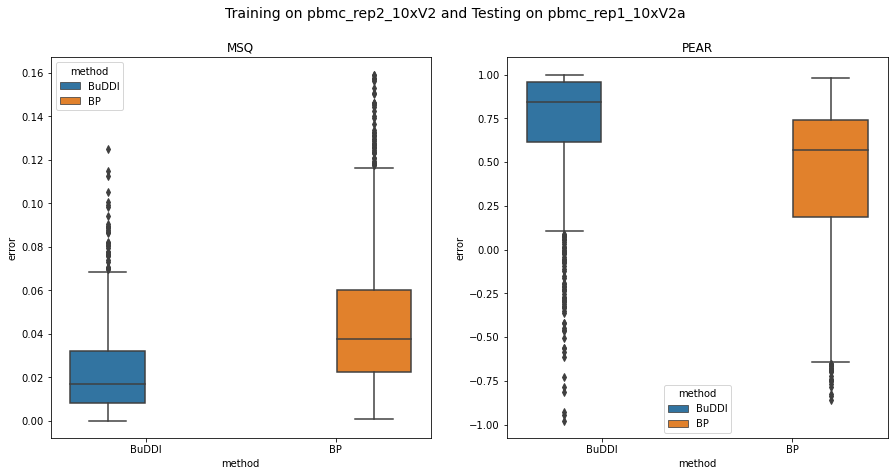

In [189]:
# first we test within the same sample
within_sample_test_diva  = read_diva_result_file(res_path, "pbmc_rep2_10xV2_sm2_cells", "pbmc_rep1_10xV2a_sm2_cells", "pbmc_rep2_10xV2_sm2_cells")
within_sample_test_bp  = read_bp_result_file(bp_res_path, "pbmc_rep2_10xV2_sm2_cells_0", "pbmc_rep1_10xV2a_sm2_cells_0", num_samp=1000)
within_sample_test_bp = within_sample_test_bp.reindex(columns=within_sample_test_diva.columns, fill_value=0)

_, Y_test_df, test_gene_df, _ = sc_preprocess.read_diva_files(data_path, 0, "pbmc_rep1_10xV2a_sm2_cells")

Y_test_df = Y_test_df[within_sample_test_diva.columns]
Y_test = Y_test_df.to_numpy()

biorep_diva_err = get_errors(Y_test, within_sample_test_diva.to_numpy())
biorep_bp_err = get_errors(Y_test, within_sample_test_bp.to_numpy())
#biorep_diva_err = get_errors(Y_test.transpose(), np.transpose(within_sample_test_diva.to_numpy()))
#biorep_bp_err = get_errors(Y_test.transpose(), np.transpose(within_sample_test_bp.to_numpy()))

biorep_diva_err["experiment"] = ["2_biorep"]*biorep_diva_err.shape[0]
biorep_diva_err["method"] = ["BuDDI"]*biorep_diva_err.shape[0]

biorep_bp_err["experiment"] = ["2_biorep"]*biorep_bp_err.shape[0]
biorep_bp_err["method"] = ["BP"]*biorep_bp_err.shape[0]

plot_df = pd.concat([biorep_diva_err, biorep_bp_err])
#plot_df = biorep_diva_err

fig, axs = plt.subplots(1, 2, figsize=(15,7))

sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="method", y="error",
            hue="method", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="method", y="error",
            hue="method", ax= axs[1])
axs[1].set_title("PEAR")
fig.suptitle("Training on pbmc_rep2_10xV2 and Testing on pbmc_rep1_10xV2a", fontsize=14)

fig.show()


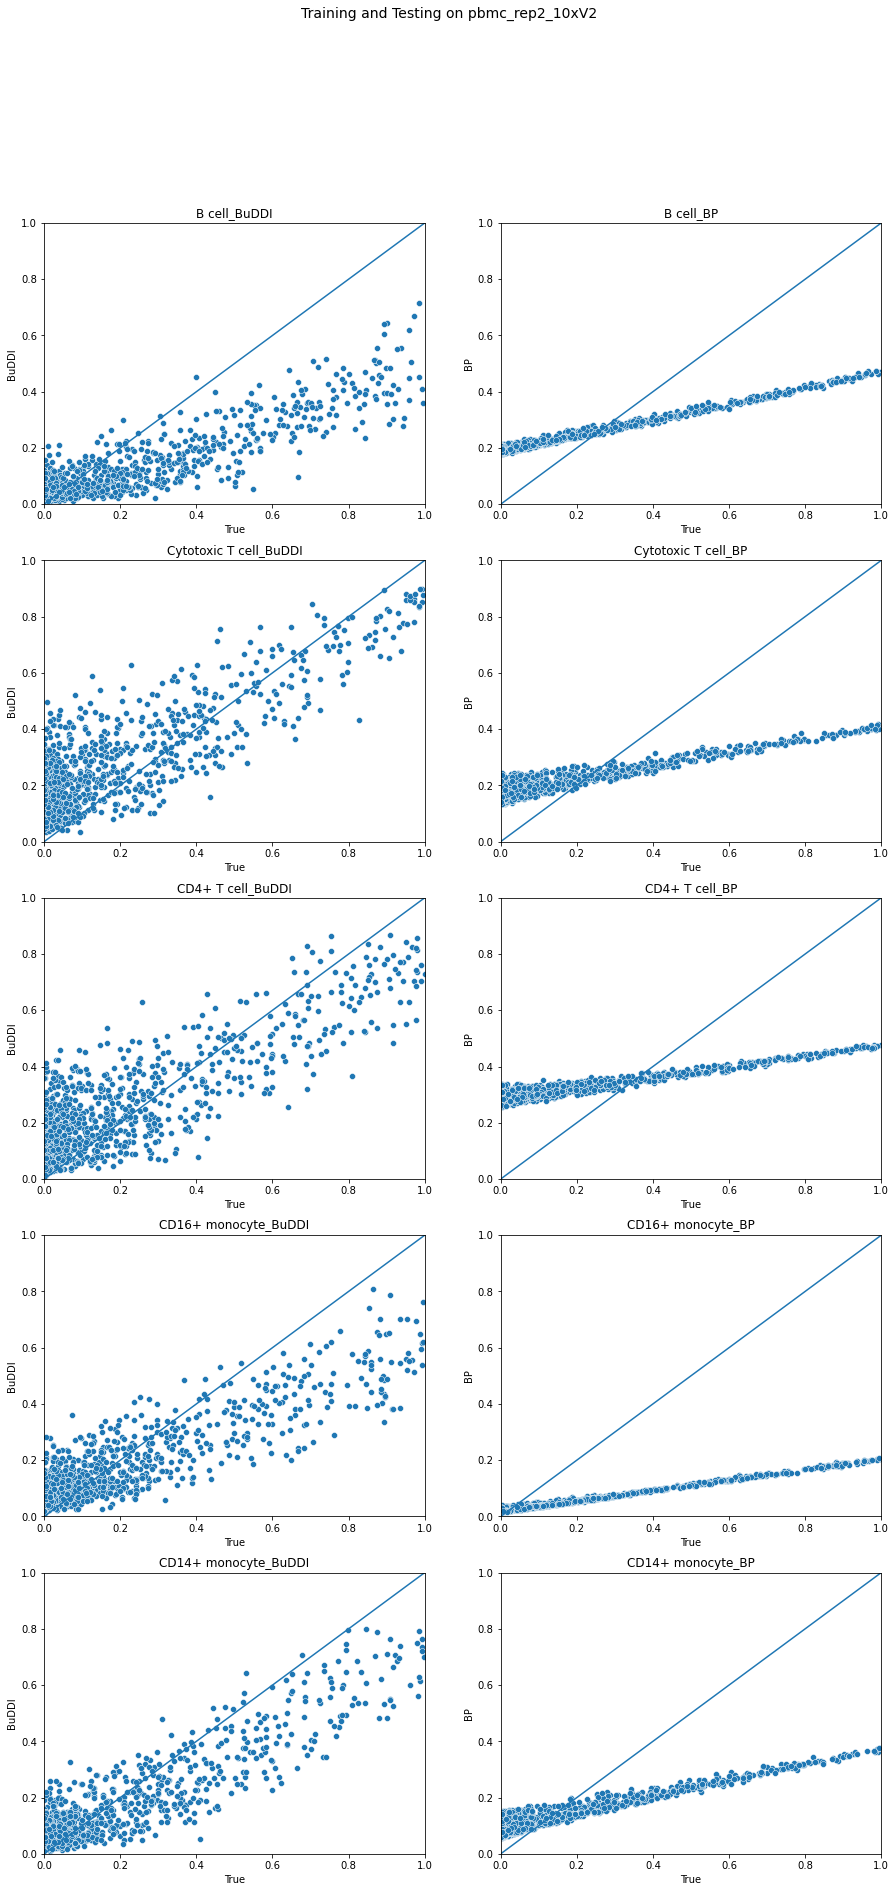

In [190]:

fig, axs = plt.subplots(5, 2, figsize=(15,30))
row_idx = 0
for curr_cell in Y_test_df.columns:

    plot_cell_specific_corr(Y_test_df[curr_cell], within_sample_test_diva[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI", xlab="True", ylab="BuDDI")
    plot_cell_specific_corr(Y_test_df[curr_cell], within_sample_test_bp[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BP", xlab="True", ylab="BP")
    row_idx = row_idx +1


fig.suptitle("Training and Testing on pbmc_rep2_10xV2", fontsize=14)

fig.show()



## Now test across bio+tech replicates

MSqE mean: 0.04355588088013205, median: 0.02140462641630983, max: 0.32799533561227123
Spearman mean: 0.39946564609006485, median: 0.49999999999999994, max: 1.0
Pearson mean: 0.6236609653043134, median: 0.8813031769881157, max: 0.9999997751197438
MSqE mean: 0.034735297318544286, median: 0.02756115371854395, max: 0.131850420103599
Spearman mean: 0.4147799030720372, median: 0.49999999999999994, max: 0.9999999999999999
Pearson mean: 0.5847511426152164, median: 0.6930915606856745, max: 0.9927460180820724


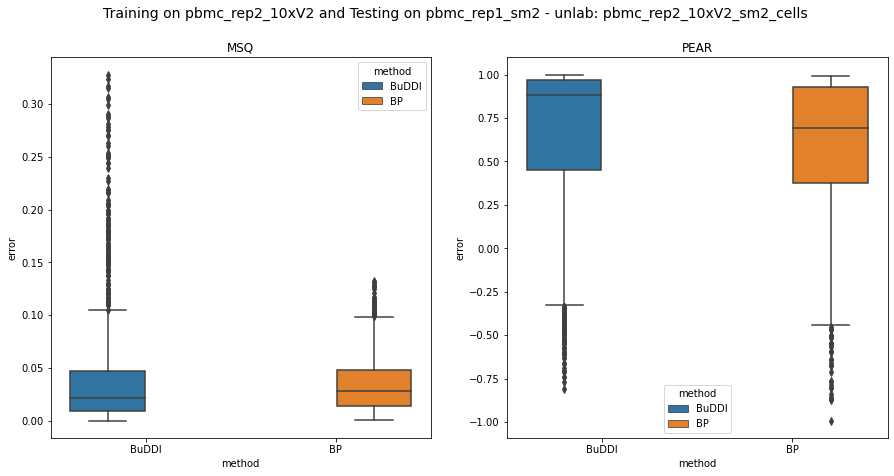

In [178]:
# first we test within the same sample
within_sample_test_diva  = read_diva_result_file(res_path, "pbmc_rep2_10xV2_sm2_cells", "pbmc_rep1_sm2", "pbmc_rep2_10xV2_sm2_cells")
within_sample_test_bp  = read_bp_result_file(bp_res_path, "pbmc_rep2_10xV2_sm2_cells_0", "pbmc_rep1_sm2_0", num_samp=1000)
within_sample_test_bp = within_sample_test_bp.reindex(columns=within_sample_test_diva.columns, fill_value=0)

_, Y_test_df, test_gene_df, _ = sc_preprocess.read_diva_files(data_path, 0, "pbmc_rep1_sm2")

Y_test_df = Y_test_df[within_sample_test_diva.columns]
Y_test = Y_test_df.to_numpy()

biorep_diva_err = get_errors(Y_test, within_sample_test_diva.to_numpy())
biorep_bp_err = get_errors(Y_test, within_sample_test_bp.to_numpy())
#biorep_diva_err = get_errors(Y_test.transpose(), np.transpose(within_sample_test_diva.to_numpy()))
#biorep_bp_err = get_errors(Y_test.transpose(), np.transpose(within_sample_test_bp.to_numpy()))

biorep_diva_err["experiment"] = ["2_biorep"]*biorep_diva_err.shape[0]
biorep_diva_err["method"] = ["BuDDI"]*biorep_diva_err.shape[0]

biorep_bp_err["experiment"] = ["2_biorep"]*biorep_bp_err.shape[0]
biorep_bp_err["method"] = ["BP"]*biorep_bp_err.shape[0]

plot_df = pd.concat([biorep_diva_err, biorep_bp_err])
#plot_df = biorep_diva_err

fig, axs = plt.subplots(1, 2, figsize=(15,7))

sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="method", y="error",
            hue="method", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="method", y="error",
            hue="method", ax= axs[1])
axs[1].set_title("PEAR")
fig.suptitle("Training on pbmc_rep2_10xV2 and Testing on pbmc_rep1_sm2 - unlab: pbmc_rep2_10xV2_sm2_cells", fontsize=14)

fig.show()


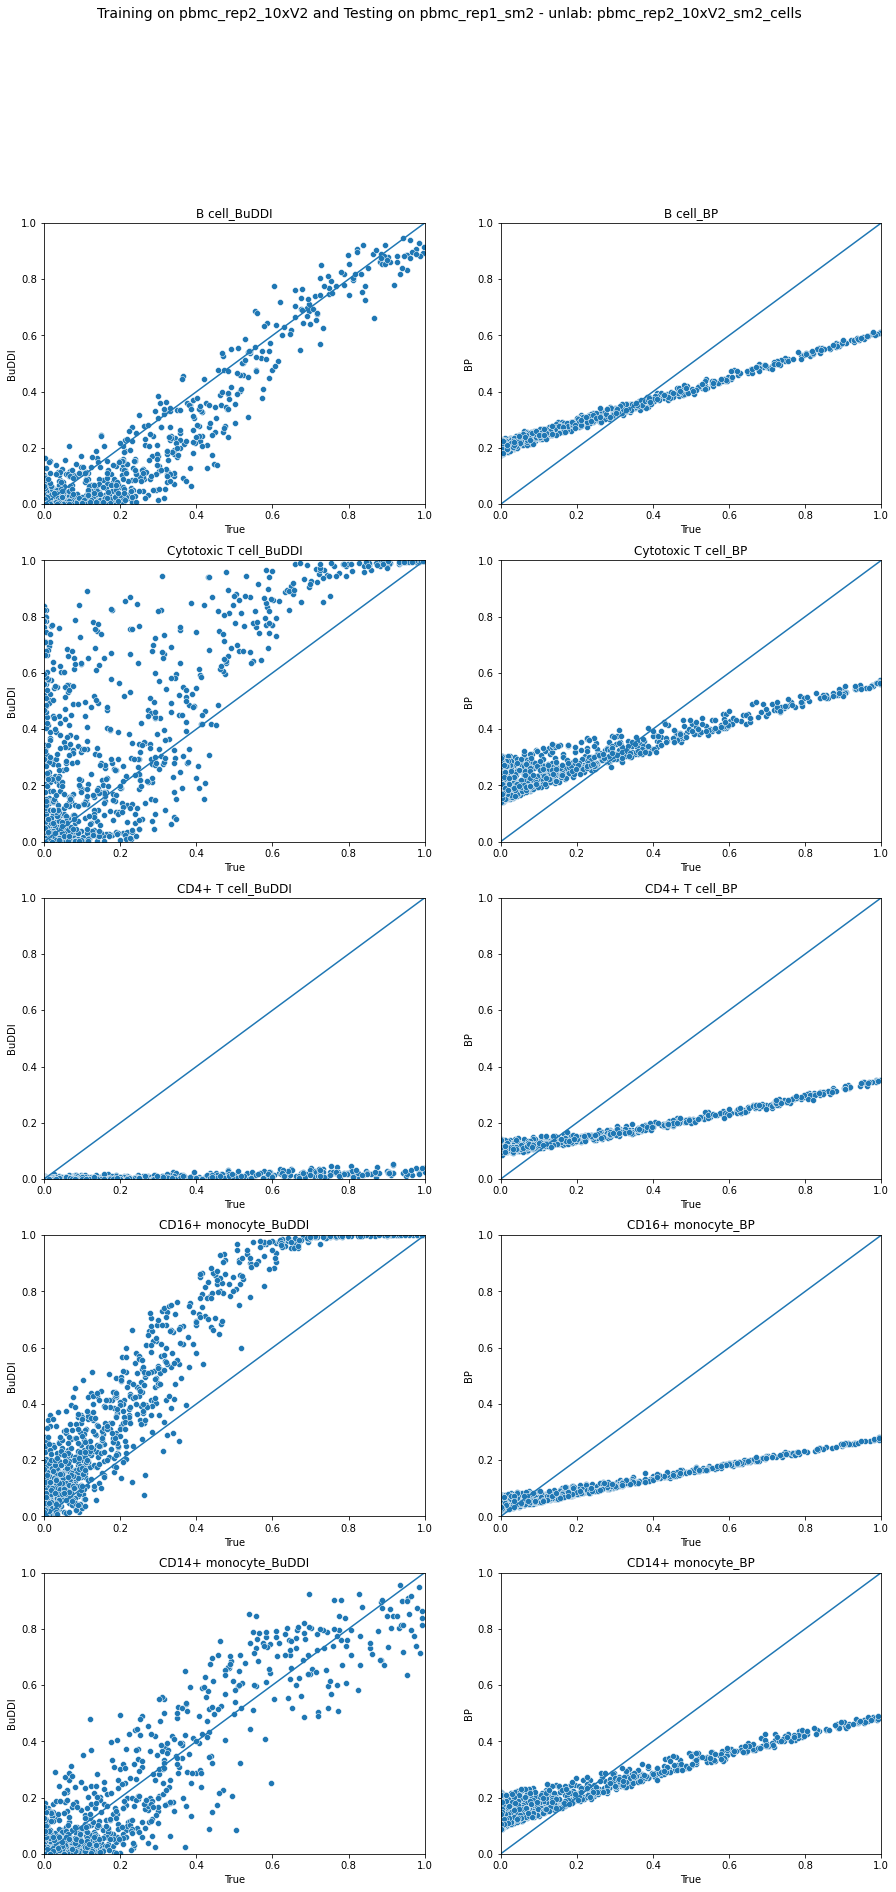

In [179]:

fig, axs = plt.subplots(5, 2, figsize=(15,30))
row_idx = 0
for curr_cell in Y_test_df.columns:

    plot_cell_specific_corr(Y_test_df[curr_cell], within_sample_test_diva[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI", xlab="True", ylab="BuDDI")
    plot_cell_specific_corr(Y_test_df[curr_cell], within_sample_test_bp[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BP", xlab="True", ylab="BP")
    row_idx = row_idx +1


fig.suptitle("Training on pbmc_rep2_10xV2 and Testing on pbmc_rep1_sm2 - unlab: pbmc_rep2_10xV2_sm2_cells", fontsize=14)

fig.show()



MSqE mean: 0.035154390973620595, median: 0.01973608764501434, max: 0.2457618721063836
Spearman mean: 0.3944966583403435, median: 0.42880246816700984, max: 0.9999999999999999
Pearson mean: 0.5757615653603816, median: 0.8142814485376728, max: 0.9999973495899291
MSqE mean: 0.03178528755021064, median: 0.02429916903190689, max: 0.11120847231738136
Spearman mean: 0.4390431137681155, median: 0.49999999999999994, max: 0.9999999999999999
Pearson mean: 0.6163387355767252, median: 0.7309899830780653, max: 0.9810065342871209


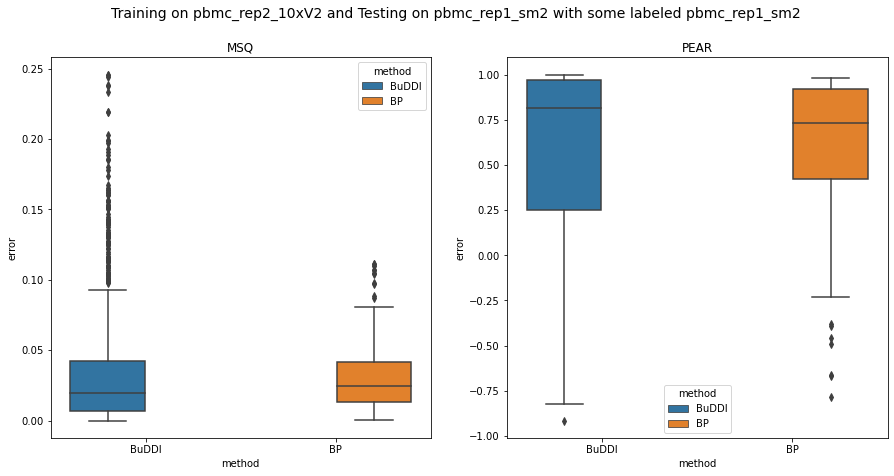

In [207]:
# first we test within the same sample
within_sample_test_diva  = read_diva_result_file(res_path, "pbmc_rep2_10xV2_sm2_cells", "pbmc_rep1_sm2", "NONE")
within_sample_test_bp  = read_bp_result_file(bp_res_path, "pbmc_rep2_10xV2_sm2_cells_0", "pbmc_rep1_sm2_0", num_samp=200)
within_sample_test_bp = within_sample_test_bp.reindex(columns=within_sample_test_diva.columns, fill_value=0)

_, Y_test_df, test_gene_df, _ = sc_preprocess.read_diva_files(data_path, 0, "pbmc_rep1_sm2")

Y_test_df = Y_test_df[within_sample_test_diva.columns]
Y_test = Y_test_df.to_numpy()

biorep_diva_err = get_errors(Y_test, within_sample_test_diva.to_numpy())
biorep_bp_err = get_errors(Y_test, within_sample_test_bp.to_numpy())
#biorep_diva_err = get_errors(Y_test.transpose(), np.transpose(within_sample_test_diva.to_numpy()))
#biorep_bp_err = get_errors(Y_test.transpose(), np.transpose(within_sample_test_bp.to_numpy()))

biorep_diva_err["experiment"] = ["2_biorep"]*biorep_diva_err.shape[0]
biorep_diva_err["method"] = ["BuDDI"]*biorep_diva_err.shape[0]

biorep_bp_err["experiment"] = ["2_biorep"]*biorep_bp_err.shape[0]
biorep_bp_err["method"] = ["BP"]*biorep_bp_err.shape[0]

plot_df = pd.concat([biorep_diva_err, biorep_bp_err])
#plot_df = biorep_diva_err

fig, axs = plt.subplots(1, 2, figsize=(15,7))

sns.boxplot(data=plot_df[plot_df["error_type"] == "MSQ"], 
            x="method", y="error",
            hue="method", ax= axs[0])
axs[0].set_title("MSQ")

sns.boxplot(data=plot_df[plot_df["error_type"] == "PEAR"], 
            x="method", y="error",
            hue="method", ax= axs[1])
axs[1].set_title("PEAR")
fig.suptitle("Training on pbmc_rep2_10xV2 and Testing on pbmc_rep1_sm2 with some labeled pbmc_rep1_sm2", fontsize=14)

fig.show()


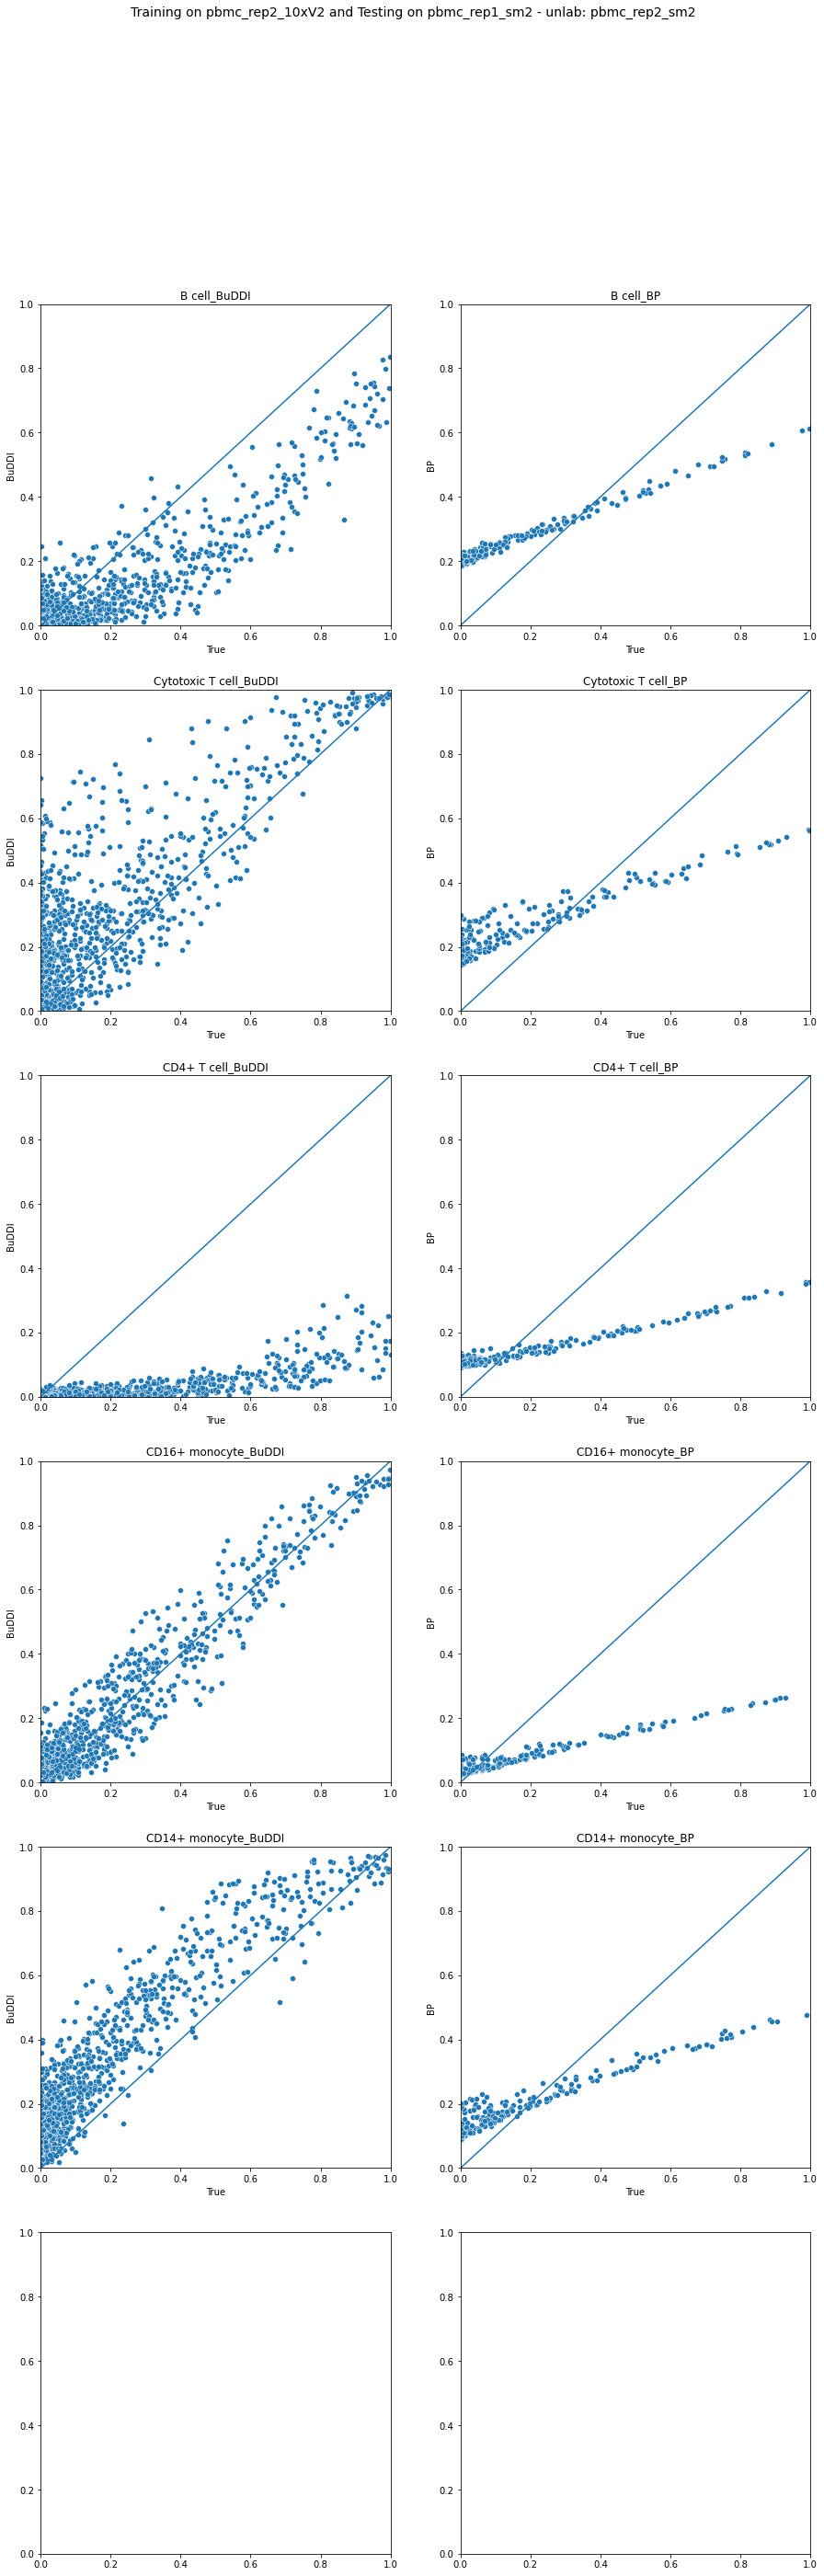

In [208]:

fig, axs = plt.subplots(6, 2, figsize=(15,45))
row_idx = 0
for curr_cell in Y_test_df.columns:

    plot_cell_specific_corr(Y_test_df[curr_cell], within_sample_test_diva[curr_cell], axs[row_idx,0], title=f"{curr_cell}_BuDDI", xlab="True", ylab="BuDDI")
    plot_cell_specific_corr(Y_test_df[curr_cell], within_sample_test_bp[curr_cell], axs[row_idx,1], title=f"{curr_cell}_BP", xlab="True", ylab="BP")
    row_idx = row_idx +1


fig.suptitle("Training on pbmc_rep2_10xV2 and Testing on pbmc_rep1_sm2 - unlab: pbmc_rep2_sm2", fontsize=14)

fig.show()

It looks like there is an issue with the CD4+ T-cells, let's investigate

In [239]:
GSE_data_path=f"{os.getcwd()}/../../data/single_cell_data/GSE132044/"
aug_data_path=f"{os.getcwd()}/../../data/single_cell_data/augmented_pbmc_data/"

old_genes_file = os.path.join(aug_data_path, "intersection_genes.pkl")
gene_out_path = Path(old_genes_file)
old_genes = pickle.load(open( gene_out_path, "rb" ))


# lets visualize the reference profiles for T-cells in sm2 and 10x
pbmc1_smart_seq2_param = pd.DataFrame({"Method":'Smart-seq2', 
                    "Experiment":'pbmc1', 
                    "min_num_cells":[-1], 
                    "num_cells":[253],
                    "file_id":'pbmc_rep1_sm2'})

pbmc2_10x_sm2_cells_param = pd.DataFrame({"Method":'10x Chromium V2', 
                    "Experiment":'pbmc2', 
                    "min_num_cells":[-1], 
                    "num_cells":[3362],
                    "file_id":'pbmc_rep2_10xV2_sm2_cells'})


sm2_cell_types = ['CD14+ monocyte', 'Cytotoxic T cell',
                'CD16+ monocyte', 'B cell',
                'CD4+ T cell', 'Megakaryocyte']



x10_cell_file = os.path.join(GSE_data_path, "GSE132044_cells_umi_new.txt")
x10_count_file = os.path.join(GSE_data_path, "GSE132044_counts_umi.txt.gz")
x10_gene_file = os.path.join(GSE_data_path, "GSE132044_genes_umi.txt")

sm2_cell_file = os.path.join(GSE_data_path, "GSE132044_cells_read_new.txt")
sm2_count_file = os.path.join(GSE_data_path, "GSE132044_counts_read.txt.gz")
sm2_gene_file = os.path.join(GSE_data_path, "GSE132044_genes_read.txt")

meta_file = os.path.join(GSE_data_path, "GSE132044_meta_counts_new.txt")
meta_tsne_file = os.path.join(GSE_data_path, "GSE132044_meta.txt")


In [221]:
sys.path.insert(1, '../../')
import pbmc_generate_data as gen_data

curr_study = pbmc2_10x_sm2_cells_param
# set the study specific parameters
min_num_cells = pd.to_numeric(curr_study["min_num_cells"][0])
method_keep = curr_study["Method"].tolist()
experiment_keep = curr_study["Experiment"].tolist()
num_cells_expected = pd.to_numeric(curr_study["num_cells"][0])
out_file_id = curr_study["file_id"][0]
gene_out_file = os.path.join(aug_data_path, f"{out_file_id}_genes.pkl")
sig_out_file = os.path.join(aug_data_path, f"{out_file_id}_sig.pkl")


x10_cell_info, x10_count_matr, x10_gene_info, x10_meta_info = gen_data.read_gse_input(x10_cell_file, 
                                                            x10_count_file, 
                                                            x10_gene_file, 
                                                            meta_file, 
                                                            meta_tsne_file)

x10_pbmc1_a_dense = gen_data.format_cell_reads_info(x10_meta_info, x10_cell_info, x10_count_matr, 
                                            num_cells_expected, method_keep, 
                                            experiment_keep)

x10_pbmc1_a_expr, x10_gene_pass = gen_data.filter_by_expr(x10_pbmc1_a_dense, min_num_cells, x10_gene_info)

x10_pbmc1_a_df, x10_expr_col = gen_data.join_metadata(x10_cell_info, x10_meta_info, x10_pbmc1_a_expr, x10_gene_pass)

col_names = pd.Series(["CellType"])
col_names = col_names.append(pbmc_rep2_10xV2_sm2_cells_train["gene_ids"])
x10_pbmc1_a_df = x10_pbmc1_a_df[col_names]



Methods used: ['Smart-seq2' 'CEL-Seq2' '10x Chromium V2 A' '10x Chromium V2 B'
 '10x Chromium V3' 'Drop-seq' 'Seq-Well' 'inDrops' '10x Chromium V2']
Experiment IDs: ['pbmc1' 'pbmc2']
Filtered table size: (22757, 3362)


In [222]:
curr_study = pbmc1_smart_seq2_param

# set the study specific parameters
min_num_cells = pd.to_numeric(curr_study["min_num_cells"][0])
method_keep = curr_study["Method"].tolist()
experiment_keep = curr_study["Experiment"].tolist()
num_cells_expected = pd.to_numeric(curr_study["num_cells"][0])
out_file_id = curr_study["file_id"][0]
gene_out_file = os.path.join(aug_data_path, f"{out_file_id}_genes.pkl")
sig_out_file = os.path.join(aug_data_path, f"{out_file_id}_sig.pkl")


sm2_cell_info, sm2_count_matr, sm2_gene_info, sm2_meta_info = gen_data.read_gse_input(sm2_cell_file, 
                                                            sm2_count_file, 
                                                            sm2_gene_file, 
                                                            meta_file, 
                                                            meta_tsne_file)

sm2_pbmc1_a_dense = gen_data.format_cell_reads_info(sm2_meta_info, sm2_cell_info, sm2_count_matr, 
                                            num_cells_expected, method_keep, 
                                            experiment_keep)

sm2_pbmc1_a_expr, sm2_gene_pass = gen_data.filter_by_expr(sm2_pbmc1_a_dense, min_num_cells, sm2_gene_info)

sm2_pbmc1_a_df, sm2_expr_col = gen_data.join_metadata(sm2_cell_info, sm2_meta_info, sm2_pbmc1_a_expr, sm2_gene_pass)

col_names = pd.Series(["CellType"])
col_names = col_names.append(pbmc_rep2_10xV2_sm2_cells_train["gene_ids"])
sm2_pbmc1_a_df = sm2_pbmc1_a_df[col_names]



Methods used: ['Smart-seq2' 'CEL-Seq2' '10x Chromium V2 A' '10x Chromium V2 B'
 '10x Chromium V3' 'Drop-seq' 'Seq-Well' 'inDrops' '10x Chromium V2']
Experiment IDs: ['pbmc1' 'pbmc2']
Filtered table size: (22654, 253)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3615 samples in 0.007s...
[t-SNE] Computed neighbors for 3615 samples in 0.616s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3615
[t-SNE] Computed conditional probabilities for sample 2000 / 3615
[t-SNE] Computed conditional probabilities for sample 3000 / 3615
[t-SNE] Computed conditional probabilities for sample 3615 / 3615
[t-SNE] Mean sigma: 18.674305
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.657578
[t-SNE] KL divergence after 300 iterations: 1.558346
(3615, 2)
(3615, 2)
Index(['B cell', 'Cytotoxic T cell', 'Dendritic cell', 'CD4+ T cell',
       'Megakaryocyte', 'Natural killer cell', 'CD16+ monocyte',
       'CD14+ monocyte', 'Plasmacytoid dendritic cell'],
      dtype='object')


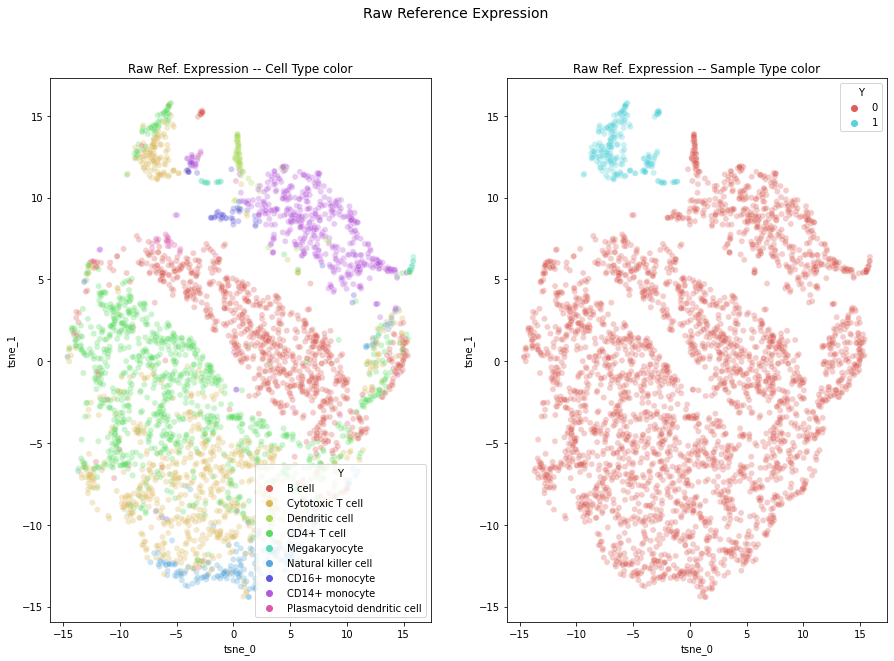

In [223]:
## now append them and plot them

# get the numeric values
x10_pbmc1_a_plot_df = x10_pbmc1_a_df[np.intersect1d(old_genes, pbmc_rep2_10xV2_sm2_cells_train["gene_ids"])]
sm2_pbmc1_a_plot_df = sm2_pbmc1_a_df[np.intersect1d(old_genes, pbmc_rep2_10xV2_sm2_cells_train["gene_ids"])]

# concatenate and make the sample ref. indicies
pbmc1_a_plot_df = pd.concat([x10_pbmc1_a_plot_df, sm2_pbmc1_a_plot_df])
cell_type_labels = x10_pbmc1_a_df['CellType'].append(sm2_pbmc1_a_df['CellType'])
cell_type_labels_num, cell_type_labels_str = pd.factorize(cell_type_labels)

text_labels = np.concatenate([np.full(x10_pbmc1_a_df.shape[0], 0), np.full(sm2_pbmc1_a_df.shape[0], 1)])

# plot
fig, axs = plt.subplots(1, 2, figsize=(15,10))

plot_df = get_tsne_for_plotting(np.asarray(pbmc1_a_plot_df))
plot_tsne(plot_df, color_vec=cell_type_labels.tolist(), ax=axs[0], title="Raw Ref. Expression -- Cell Type color")
plot_tsne(plot_df, color_vec=text_labels, ax=axs[1], title="Raw Ref. Expression -- Sample Type color")


fig.suptitle("Raw Reference Expression", fontsize=14)

fig.show()

print(cell_type_labels_str)

In [244]:
marker_genes = ['ENSG00000153563_CD8A', 'ENSG00000168685_IL7R', 'ENSG00000126353_CCR7', 'ENSG00000196154_S100A4', 'ENSG00000156738_MS4A1', 'ENSG00000170458_CD14']

x10_median_by_cell_type = x10_pbmc1_a_df.groupby(["CellType"])[marker_genes].mean()
x10_median_by_cell_type


ENSG00000153563_CD8A  ENSG00000168685_IL7R  \
CellType                                                                  
B cell                                   0.022042              0.103248   
CD14+ monocyte                           0.013761              0.121560   
CD16+ monocyte                           0.040000              0.280000   
CD4+ T cell                              0.147456              2.449637   
Cytotoxic T cell                         0.757925              1.508646   
Dendritic cell                           0.092105              0.250000   
Megakaryocyte                            0.093750              0.000000   
Natural killer cell                      0.200913              0.082192   
Plasmacytoid dendritic cell              0.066667              0.466667   

                             ENSG00000126353_CCR7  ENSG00000196154_S100A4  \
CellType                                                                    
B cell                                   0.307425                0.583527   
CD14+ monocyte                           0.055046               12.135321   
CD16+ monocyte                           0.060000               24.800000   
CD4+ T cell                              0.800623                2.401869   
Cytotoxic T cell                         0.044669                4.713256   
Dendritic cell                           0.065789               21.328947   
Megakaryocyte                            0.000000                0.093750   
Natural killer cell                      0.013699                3.260274   
Plasmacytoid dendritic cell              0.200000                2.566667   

                             ENSG00000156738_MS4A1  ENSG00000170458_CD14  
CellType                                                                  
B cell                                    2.778422              0.010441  
CD14+ monocyte                            0.064220              1.250000  
CD16+ monocyte                            0.040000              0.300000  
CD4+ T cell                               0.059190              0.006231  
Cytotoxic T cell                          0.082133              0.007205  
Dendritic cell                            0.276316              0.447368  
Megakaryocyte                             0.000000              0.031250  
Natural killer cell                       0.045662              0.004566  
Plasmacytoid dendritic cell               0.100000              0.033333

In [243]:
sm2_median_by_cell_type = sm2_pbmc1_a_df.groupby(["CellType"])[marker_genes].median()
sm2_median_by_cell_type

ENSG00000153563_CD8A  ENSG00000168685_IL7R  \
CellType                                                       
B cell                             0.0                   0.0   
CD14+ monocyte                     0.0                   0.0   
CD16+ monocyte                     0.0                   0.0   
CD4+ T cell                        0.0                 304.0   
Cytotoxic T cell                 326.0                   0.0   
Megakaryocyte                      0.0                   0.0   

                  ENSG00000126353_CCR7  ENSG00000196154_S100A4  \
CellType                                                         
B cell                            36.5                     0.0   
CD14+ monocyte                     0.0                   355.5   
CD16+ monocyte                     0.0                   405.0   
CD4+ T cell                        0.0                    79.0   
Cytotoxic T cell                   0.0                   143.0   
Megakaryocyte                      0.0                     0.0   

                  ENSG00000156738_MS4A1  ENSG00000170458_CD14  
CellType                                                       
B cell                            412.0                   0.0  
CD14+ monocyte                      0.0                1385.0  
CD16+ monocyte                      0.0                   0.0  
CD4+ T cell                         0.0                   0.0  
Cytotoxic T cell                    0.0                   0.0  
Megakaryocyte                       0.0                   0.0

In [240]:
np.intersect1d(old_genes, marker_genes)

array(['ENSG00000126353_CCR7', 'ENSG00000153563_CD8A',
       'ENSG00000156738_MS4A1', 'ENSG00000168685_IL7R',
       'ENSG00000170458_CD14', 'ENSG00000196154_S100A4'], dtype='<U34')

In [235]:
feat_genes_file = os.path.join(res_path, "train-pbmc_rep2_10xV2_sm2_cells-pbmc_rep2_10xV2_sm2_cells-DIVA_features.pkl")
feat_genes_path = Path(feat_genes_file)
feat_genes = pickle.load(open( feat_genes_path, "rb" ))
np.intersect1d(feat_genes, marker_genes)

array(['ENSG00000126353_CCR7', 'ENSG00000153563_CD8A',
       'ENSG00000156738_MS4A1', 'ENSG00000168685_IL7R',
       'ENSG00000170458_CD14', 'ENSG00000196154_S100A4'], dtype=object)

In [241]:
np.intersect1d(feat_genes, old_genes).shape

(10000,)

In [238]:
print(f"feat_genes: {feat_genes.shape}, old_genes: {old_genes.shape}, ")

feat_genes: (10000, 1), old_genes: (5316,), 


In [226]:
cd4_x10_median_by_cell_type = scale(x10_median_by_cell_type.loc['CD4+ T cell'])
cd4_sm2_median_by_cell_type = scale(sm2_median_by_cell_type.loc['CD4+ T cell'])
print(pearsonr(cd4_x10_median_by_cell_type, cd4_sm2_median_by_cell_type))


b_x10_median_by_cell_type = scale(x10_median_by_cell_type.loc['B cell'])
b_sm2_median_by_cell_type = scale(sm2_median_by_cell_type.loc['B cell'])
print(pearsonr(b_x10_median_by_cell_type, b_sm2_median_by_cell_type))

cd16_x10_median_by_cell_type = scale(x10_median_by_cell_type.loc['CD16+ monocyte'])
cd16_sm2_median_by_cell_type = scale(sm2_median_by_cell_type.loc['CD16+ monocyte'])
print(pearsonr(cd16_x10_median_by_cell_type, cd16_sm2_median_by_cell_type))

print(pearsonr(b_x10_median_by_cell_type, cd4_sm2_median_by_cell_type))
print(pearsonr(cd16_x10_median_by_cell_type, cd4_sm2_median_by_cell_type))


ValueError: x and y must have the same length.

In [ ]:
within_sample_test_diva  = read_diva_result_file(res_path, "pbmc_rep2_10xV2_sm2_cells", "pbmc_rep1_sm2", "pbmc_rep2_10xV2_sm2_cells")
within_sample_test_diva

B cell  Cytotoxic T cell  CD4+ T cell  Megakaryocyte  CD16+ monocyte  \
0    0.001640          0.011717     0.000364       0.967631        0.015435   
1    0.063811          0.045340     0.008564       0.161037        0.719151   
2    0.008917          0.548855     0.116214       0.250087        0.071703   
3    0.000553          0.996677     0.000003       0.001915        0.000642   
4    0.557562          0.212485     0.002565       0.105988        0.115345   
..        ...               ...          ...            ...             ...   
995  0.712125          0.056961     0.002493       0.055565        0.127816   
996  0.058860          0.128384     0.001958       0.380884        0.407867   
997  0.102018          0.248793     0.092267       0.494835        0.055216   
998  0.691785          0.016127     0.001529       0.071926        0.217382   
999  0.086379          0.039035     0.010175       0.509781        0.208660   

     CD14+ monocyte  
0          0.003213  
1          0.002097  
2          0.004223  
3          0.000211  
4          0.006055  
..              ...  
995        0.045040  
996        0.022047  
997        0.006871  
998        0.001251  
999        0.145970  

[1000 rows x 6 columns]

## Lets summarize the results below

In [ ]:
def run_analysis(res_path, data_path, num_samp_bp, train_id, test_id, unlab_id):

    bp_train = f"{train_id}_0"
    bp_test = f"{test_id}_0"

    # across rep and tech
    within_sample_test_diva  = read_diva_result_file(res_path, train_id, test_id, unlab_id)
    within_sample_test_bp  = read_bp_result_file(bp_res_path, bp_train, bp_test, num_samp=num_samp_bp)
    within_sample_test_bp = within_sample_test_bp.reindex(columns=within_sample_test_diva.columns, fill_value=0)

    X_test, Y_test_df, test_gene_df, _ = sc_preprocess.read_diva_files(data_path, 0, test_id)
    Y_test_df = Y_test_df.reindex(columns=within_sample_test_diva.columns, fill_value=0)
    Y_test = Y_test_df.to_numpy()

    biorep_diva_err = get_errors(Y_test, within_sample_test_diva.to_numpy())
    biorep_bp_err = get_errors(Y_test, within_sample_test_bp.to_numpy())
    #biorep_diva_err = get_errors(Y_test.transpose(), np.transpose(within_sample_test_diva.to_numpy()))
    #biorep_bp_err = get_errors(Y_test.transpose(), np.transpose(within_sample_test_bp.to_numpy()))

    biorep_diva_err["experiment"] = ["2_biorep"]*biorep_diva_err.shape[0]
    biorep_diva_err["method"] = ["BuDDI"]*biorep_diva_err.shape[0]

    biorep_bp_err["experiment"] = ["2_biorep"]*biorep_bp_err.shape[0]
    biorep_bp_err["method"] = ["BP"]*biorep_bp_err.shape[0]

    return plot_df, Y_test_df, within_sample_test_diva, within_sample_test_bp


In [ ]:
num_samp_bp = 1000
train_id = "pbmc_rep2_10xV2_sm2_cells"
test_id = "pbmc_rep2_10xV2_sm2_cells"
unlab_id = "pbmc_rep2_10xV2_sm2_cells"

plot_df, _, _, _ = run_analysis(res_path, data_path, num_samp_bp, train_id, test_id, unlab_id)

MSqE mean: 0.011396030276583083, median: 0.007401032512769131, max: 0.07737333793637417
Spearman mean: 0.6357707297539027, median: 0.7, max: 1.0
Pearson mean: 0.8379233633997774, median: 0.938757415995933, max: 0.9999754938004533
MSqE mean: 0.036736774919826985, median: 0.02867831106928745, max: 0.14221762016701073
Spearman mean: 0.45200474873007057, median: 0.49999999999999994, max: 0.9999999999999999
Pearson mean: 0.566160374014725, median: 0.7172749384348206, max: 0.9881216228852105


In [ ]:
num_samp_bp = 1000
train_id = "pbmc_rep2_10xV2_sm2_cells"
test_id = "pbmc_rep1_10xV2a_sm2_cells"
unlab_id = "pbmc_rep2_10xV2_sm2_cells"

plot_df, _, _, _ = run_analysis(res_path, data_path, num_samp_bp, train_id, test_id, unlab_id)

MSqE mean: 0.02275218513578425, median: 0.0167916225378741, max: 0.12490251672695643
Spearman mean: 0.549757908266291, median: 0.6, max: 0.9999999999999999
Pearson mean: 0.7219042804662148, median: 0.8453646005781352, max: 0.9998656639960041
MSqE mean: 0.044965142964699625, median: 0.0377450270673976, max: 0.1591692607339542
Spearman mean: 0.3164827368565199, median: 0.35909242322980395, max: 0.9999999999999999
Pearson mean: 0.41864305947056357, median: 0.5688777588021967, max: 0.9786969485181515


In [ ]:
num_samp_bp = 1000
train_id = "pbmc_rep2_10xV2_sm2_cells"
test_id = "pbmc_rep1_sm2"
unlab_id = "pbmc_rep2_10xV2_sm2_cells"

plot_df, _, _, _ = run_analysis(res_path, data_path, num_samp_bp, train_id, test_id, unlab_id)

MSqE mean: 0.04355588088013205, median: 0.02140462641630983, max: 0.32799533561227123
Spearman mean: 0.39946564609006485, median: 0.49999999999999994, max: 1.0
Pearson mean: 0.6236609653043134, median: 0.8813031769881157, max: 0.9999997751197438
MSqE mean: 0.034735297318544286, median: 0.02756115371854395, max: 0.131850420103599
Spearman mean: 0.4147799030720372, median: 0.49999999999999994, max: 0.9999999999999999
Pearson mean: 0.5847511426152164, median: 0.6930915606856745, max: 0.9927460180820724


In [ ]:
num_samp_bp = 1000
train_id = "pbmc_rep2_10xV2_sm2_cells"
test_id = "pbmc_rep1_sm2"
unlab_id = "pbmc_rep2_sm2"

plot_df, _, _, _ = run_analysis(res_path, data_path, num_samp_bp, train_id, test_id, unlab_id)

MSqE mean: 0.057952509349309726, median: 0.040342085773847916, max: 0.3916731324742087
Spearman mean: 0.24108005002749314, median: 0.3, max: 1.0
Pearson mean: 0.30330995811100303, median: 0.3406179035774308, max: 0.9999701717616944
MSqE mean: 0.034735297318544286, median: 0.02756115371854395, max: 0.131850420103599
Spearman mean: 0.4147799030720372, median: 0.49999999999999994, max: 0.9999999999999999
Pearson mean: 0.5847511426152164, median: 0.6930915606856745, max: 0.9927460180820724


In [ ]:
num_samp_bp = 1000
train_id = "pbmc_rep2_10xV2_sm2_cells"
test_id = "pbmc_rep1_sm2"
unlab_id = "pbmc_rep1_sm2"

plot_df, _, _, _ = run_analysis(res_path, data_path, num_samp_bp, train_id, test_id, unlab_id)

MSqE mean: 0.05284653976079784, median: 0.03999997934794376, max: 0.34253452787466554
Spearman mean: 0.2583140054393166, median: 0.3, max: 0.9999999999999999
Pearson mean: 0.33168057423651653, median: 0.40401787085478835, max: 0.9999853304640797
MSqE mean: 0.034735297318544286, median: 0.02756115371854395, max: 0.131850420103599
Spearman mean: 0.4147799030720372, median: 0.49999999999999994, max: 0.9999999999999999
Pearson mean: 0.5847511426152164, median: 0.6930915606856745, max: 0.9927460180820724


In [ ]:
np.random.lognormal(0, 1, 10)

array([0.22424328, 3.59080749, 0.63242078, 0.41145117, 0.8318435 ,
       0.98281192, 0.62487057, 0.73090159, 0.09485213, 1.47221283])